<a href="https://colab.research.google.com/github/indhu68/Intro_to_DL_Project/blob/main/RTML1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.3 MB/s eta 0:00:00


In [ ]:
!pip install haversine

In [ ]:

import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch_geometric.nn import GINConv, global_mean_pool
from itertools import combinations


In [ ]:

from google.colab import drive
drive.mount('/content/drive')
# Load data
df = pd.read_csv('/content/drive/My Drive/Kasungu_Telemetry_Pts_Oct23.csv', parse_dates=['Time.Stamp'])
df

Mounted at /content/drive


,Index,Tag,Type,Latitude,Longitude,Time.Stamp,DOP,Speed,Battery,Movement,Alarm,RSSI,Coverage,Retries,SW_Ver_,Time_Stamp,Log_Interv,Temperatur,Accelerome,SW.Ver.
0,10000,5748,IR-SAT Tag,-13.027828,33.133265,2022-07-14 11:08:00,10 meters,3 km/h,3.68 Volt,Y,N,5,N,4,66,7/14/2022,Every 30 minutes,41,"[1033,5505,15905]",66
1,10001,5744,IR-SAT Tag,-13.224110,33.157962,2022-07-14 11:10:00,<10 meters,0 km/h,3.65 Volt,Y,N,4,Y,0,66,7/14/2022,Every 30 minutes,41,"[1222,-960,15876]",66
2,10002,5740,IR-SAT Tag,-13.050495,33.152538,2022-07-14 11:23:00,10 meters,0 km/h,3.68 Volt,Y,N,5,N,2,66,7/14/2022,Every 30 minutes,39,"[-1007,203,15311]",66
3,10005,5746,IR-SAT Tag,-13.061195,33.182005,2022-07-14 11:24:00,10 meters,2 km/h,3.66 Volt,Y,N,3,N,2,66,7/14/2022,Every 30 minutes,41,"[2940,984,14900]",66
4,10006,5745,IR-SAT Tag,-13.007968,33.104750,2022-07-14 11:24:00,10 meters,0 km/h,3.67 Volt,Y,N,5,N,2,66,7/14/2022,Every 30 minutes,40,"[721,-1718,15198]",66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383055,9995,5751,IR-SAT Tag,-12.732593,33.183252,2023-08-16 00:04:00,10 meters,0 km/h,3.66 Volt,Y,N,2,N,3,66,8/16/2023,Every 1 hour,25,"[-441,284,15724]",66
383056,9996,5750,IR-SAT Tag,-12.730062,33.184862,2023-08-16 00:06:00,10 meters,2 km/h,3.64 Volt,Y,N,1,Y,0,66,8/16/2023,Every 1 hour,26,"[-1446,818,15792]",66
383057,9997,5757,IR-SAT Tag,-12.719173,33.082990,2023-08-16 00:12:00,10 meters,0 km/h,3.68 Volt,Y,N,4,Y,0,66,8/16/2023,Every 1 hour,23,"[-14394,1689,6386]",66
383058,9998,5743,IR-SAT Tag,-13.035063,33.221140,2023-08-16 00:17:00,10 meters,0 km/h,3.69 Volt,Y,N,5,Y,0,66,8/16/2023,Every 1 hour,22,"[2096,3363,15104]",66


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

class GeoDataset(Dataset):
    def __init__(self, csv_file, sequence_length=5):
        self.data = pd.read_csv(csv_file)
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
      sequence = self.data.iloc[idx:idx + self.sequence_length + 1]
      latitudes = sequence['Latitude'].values
      longitudes = sequence['Longitude'].values
      # Corrected the placement of dtype=np.float32 to the tensor creation
      sample = {'sequence': torch.tensor(np.column_stack((latitudes[:-1], longitudes[:-1])), dtype=torch.float32),
                'target': torch.tensor([latitudes[-1], longitudes[-1]], dtype=torch.float32)}
      return sample

# Usage example:
dataset = GeoDataset('/content/drive/My Drive/Kasungu_Telemetry_Pts_Oct23.csv')
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


In [ ]:
import torch.nn as nn

class GeoRNN(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, num_layers=2):
        super(GeoRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # We are only interested in the last output
        return out

# Example of model creation:
model = GeoRNN()


In [ ]:
import torch
import numpy as np

def predict_trajectory(model, initial_sequence, steps):
    model.eval()  # Switch model to evaluation mode
    current_sequence = initial_sequence
    predicted_trajectory = [current_sequence[-1]]  # Start with the last point of the initial sequence

    for _ in range(steps):
        with torch.no_grad():
            current_sequence_tensor = torch.tensor(current_sequence).unsqueeze(0).float()  # Convert to tensor and add batch dimension
            predicted_point = model(current_sequence_tensor)  # Predict the next point
            predicted_point = predicted_point.squeeze().detach().numpy()  # Convert predicted point to numpy array
            predicted_trajectory.append(predicted_point)  # Append the predicted point to the trajectory
            current_sequence = np.vstack((current_sequence[1:], predicted_point))  # Update sequence with the new point

    return np.array(predicted_trajectory)


In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
losses = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in dataloader:
        sequences = batch['sequence']
        targets = batch['target']

        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    epoch_loss = total_loss / len(dataloader)
    losses.append(epoch_loss)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')



Epoch 1, Loss: 0.023554496438254312
Epoch 2, Loss: 0.02356783904483813
Epoch 3, Loss: 0.02358242453561796
Epoch 4, Loss: 0.023593514084071423
Epoch 5, Loss: 0.023592853635866887
Epoch 6, Loss: 0.02358438815359913
Epoch 7, Loss: 0.02361102573774526
Epoch 8, Loss: 0.023598595058115467
Epoch 9, Loss: 0.023603942717238577
Epoch 10, Loss: 0.02358607788135573


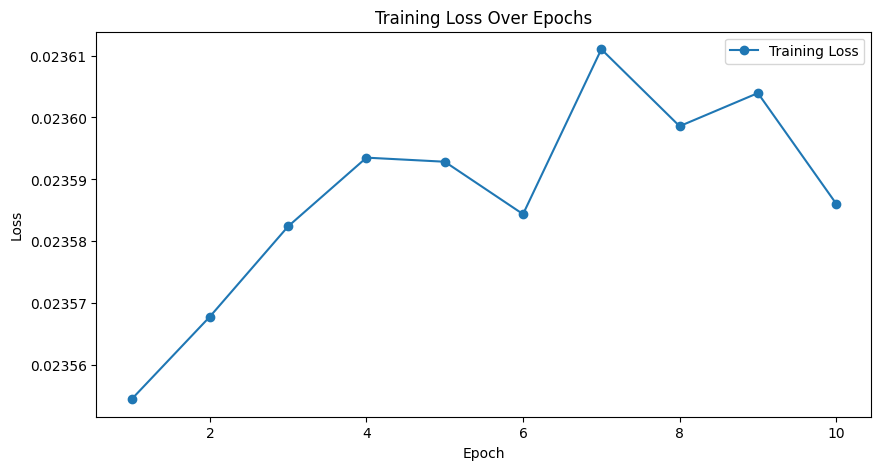

In [ ]:
# Plotting the training losses
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

<ipython-input-13-dada0357d3b7>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_sequence_tensor = torch.tensor(current_sequence).unsqueeze(0).float()  # Convert to tensor and add batch dimension


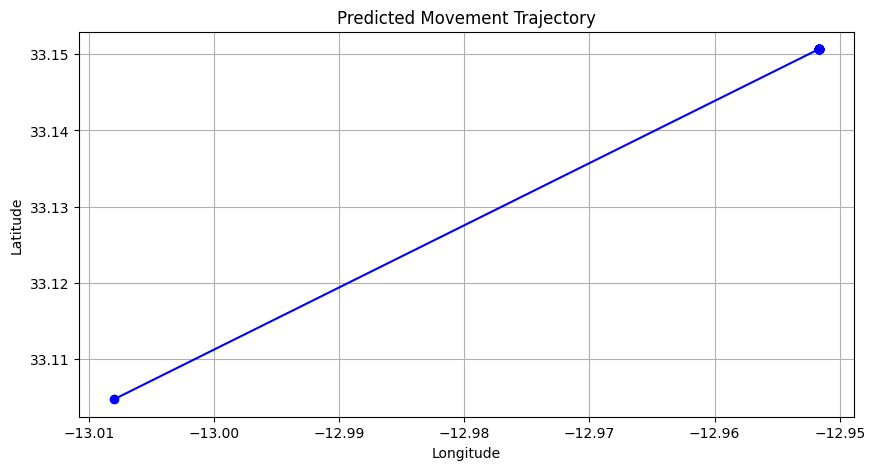

In [ ]:
# Prediction of movement after training
initial_sequence = dataset[0]['sequence']  # Using the first sequence in the dataset as the starting point
predicted_trajectory = predict_trajectory(model, initial_sequence, steps=20)

# Plotting the predicted trajectory
plt.figure(figsize=(10, 5))
plt.plot(predicted_trajectory[:, 0], predicted_trajectory[:, 1], marker='o', linestyle='-', color='blue')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Predicted Movement Trajectory')
plt.grid(True)
plt.show()